##### ▶ライブラリ

In [117]:
import pandas as pd
import numpy as np
import requests
import io
import math
import copy
from scipy.stats import gmean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from pipeline_functions import PipelineFunctions
pf = PipelineFunctions()
from view_functions import ViewFunctions
vf = ViewFunctions()

import umap
from sklearn.manifold import TSNE
import seaborn as sns
palette = ['#CC521D', '#4F4AD7', '#39AE3D']

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [127]:
def show_plot(x, y, color):
    plt.rcParams['font.family'] = 'Times New Roman'
    PLOT_COLOER= 'green'
    FACE_COLOR = 'white'
    PLOT_WIDTH = 0.5
    FIG_SIZE = (10, 5)
    fig, ax = plt.subplots(facecolor=FACE_COLOR, figsize=(FIG_SIZE[0],FIG_SIZE[1]))
    ax.set_ylim([0, 1])    # y方向の描画範囲を指定
    ax.set_facecolor(FACE_COLOR)
    ax.plot(x, y, color=color, linewidth=PLOT_WIDTH)  
    plt.show()
    plt.close()
    return

##### ▶予測データ

In [124]:
predict = pd.read_csv('../temp/fail_classify_stroke.csv', delimiter=',', index_col=0)
score = pd.read_csv('../temp/complie_result_csv/compile_result_knn.csv', delimiter=',', index_col=0)
tp = predict.query('is_good_saito == 1').query('knn_predict == 1')
tn = predict.query('is_good_saito == 0').query('knn_predict == 0')
fp = predict.query('is_good_saito == 0').query('knn_predict == 1')  # precisionに関係
fn = predict.query('is_good_saito == 1').query('knn_predict == 0')  # recallに関係

##### ▶t_SNEとUMAPで可視化

C:\Users\ispec\AppData\Local\Temp\ipykernel_13732\1259062462.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x='tsne_ax0', y='tsne_ax1', hue=predict['knn_predict'], data=predict, palette=palette, alpha=0.5)


<AxesSubplot: xlabel='tsne_ax0', ylabel='tsne_ax1'>

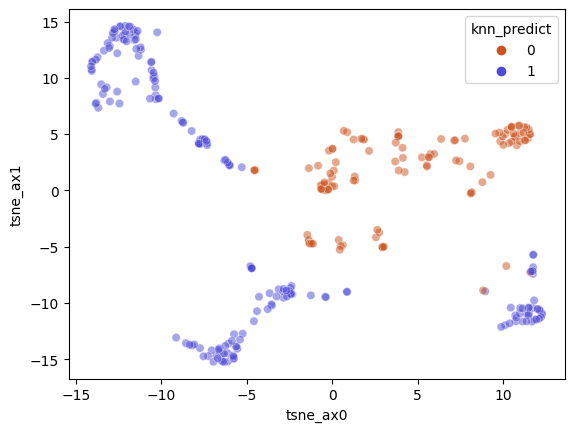

In [45]:
import umap
from sklearn.manifold import TSNE
embed_col = [f'feature_{i}' for i in [0, 1, 2, 3, 4, 5]]
embed_X = predict[embed_col].to_numpy()

##### t_SNE #####
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, metric='euclidean', init='pca', random_state=1)
tsne_result = tsne.fit_transform(embed_X)
predict['tsne_ax0'] = tsne_result[:, 0:1]
predict['tsne_ax1'] = tsne_result[:, 1:2]
sns.scatterplot(x='tsne_ax0', y='tsne_ax1', hue=predict['knn_predict'], data=predict, palette=palette, alpha=0.5)
# sns.scatterplot(x='tsne_ax0', y='tsne_ax1', hue=predict['is_good_saito'], data=predict, palette=palette, alpha=0.5)
# sns.scatterplot(x='tsne_ax0', y='tsne_ax1', hue=predict['is_good_rulebase'], data=predict, palette=palette, alpha=0.5)
# sns.scatterplot(x='tsne_ax0', y='tsne_ax1', hue=predict['saito_label'], data=predict, palette=palette, alpha=0.5)

##### UMAP #####
# umap = umap.UMAP(n_components=2, 
#                 n_neighbors=15,
#                 min_dist=0.1,
#                 metric = "euclidean"
#                 )
# umap_result = umap.fit_transform(embed_X)
# predict['umap_ax0'] = umap_result[:, 0:1]
# predict['umap_ax1'] = umap_result[:, 1:2]
# sns.scatterplot(x='umap_ax0', y='umap_ax1', hue=predict['knn_predict'], data=predict, palette=palette, alpha=0.5)

##### ▶誤判定ストロークの特徴量を可視化

In [156]:
assessment = tn

for i, row in assessment.iterrows():
    y = [row[f'feature_{i}'] for i in range(6)]
    fig = plt.subplots(figsize=(3, 2))
    plt.ylim([-1, 1])
    plt.plot(range(len(y)), y, color='blue', marker='.')
    # plt.show()
    did, sid = row['drawing_id'], row['stroke_id']
    plt.savefig(f'../temp/stroke_img/tn/{did}_{sid}.png')
    plt.close()

##### ▶kごとのF-measure

10504


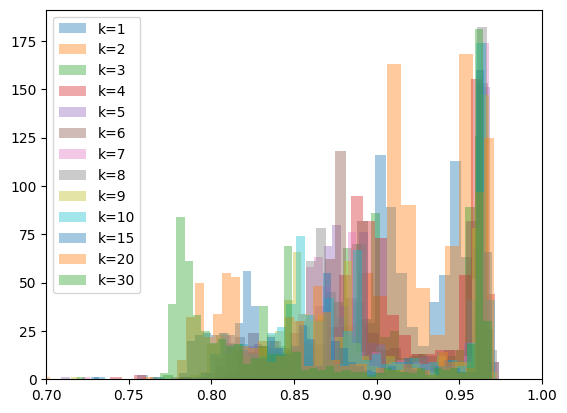

In [77]:
score_type = 'kfold_mean_f1'
each_k_score = {}
for k in score['n_neighbors'].unique():
    each_k_score[f'k={k}'] = score.query('n_neighbors == @k').reset_index()[score_type]
each_k_score = pd.DataFrame(each_k_score)

plt.xlim([0.7, 1])
for k in each_k_score:
    plt.hist(each_k_score[k], bins=50, alpha=0.4, label=k)
plt.legend()

print(len(score))

##### ▶座標数ごとの精度を確認

KruskalResult(statistic=532.7881895524745, pvalue=2.025417821889004e-116)
MannwhitneyuResult(statistic=7573491.0, pvalue=6.488455476596785e-67)
MannwhitneyuResult(statistic=6746686.0, pvalue=4.8603537753469955e-12)
MannwhitneyuResult(statistic=4311057.0, pvalue=3.194642964241413e-101)


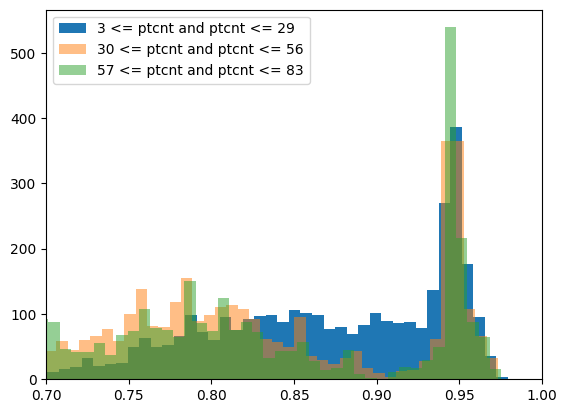

In [116]:
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

score_col = 'kfold_mean_precision' 

ptcnt_1 = score.query('3 <= ptcnt and ptcnt <= 29')
ptcnt_2 = score.query('30 <= ptcnt and ptcnt <= 56')
ptcnt_3 = score.query('57 <= ptcnt and ptcnt <= 83')

plt.xlim([0.7, 1])
plt.hist(ptcnt_1[score_col], bins=50, label='3 <= ptcnt and ptcnt <= 29')
plt.hist(ptcnt_2[score_col], bins=50, alpha=0.5, label='30 <= ptcnt and ptcnt <= 56')
plt.hist(ptcnt_3[score_col], bins=50, alpha=0.5, label='57 <= ptcnt and ptcnt <= 83')
plt.legend()

print(kruskal(ptcnt_1[score_col], ptcnt_2[score_col], ptcnt_3[score_col]))
print(mannwhitneyu(ptcnt_1[score_col], ptcnt_2[score_col], alternative='two-sided'))
print(mannwhitneyu(ptcnt_2[score_col], ptcnt_3[score_col], alternative='two-sided'))
print(mannwhitneyu(ptcnt_3[score_col], ptcnt_1[score_col], alternative='two-sided'))


##### ▶特徴量ごとの精度を確認

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0., 16., 25., 28., 25., 30., 35., 35., 43., 51.,
        36., 42., 32., 39., 38., 39., 27., 37., 30., 29., 27., 18., 22.,
        32., 26., 36., 34., 33., 27., 47., 29., 34., 21., 14.]),
 array([0.68018534, 0.68591028, 0.69163521, 0.69736015, 0.70308508,
        0.70881001, 0.71453495, 0.72025988, 0.72598482, 0.73170975,
        0.73743469, 0.74315962, 0.74888456, 0.75460949, 0.76033443,
        0.76605936, 0.7717843 , 0.77750923, 0.78323417, 0.7889591 ,
        0.79468404, 0.80040897, 0.80613391, 0.81185884, 0.81758378,
        0.82330871, 0.82903365, 0.83475858, 0.84048352, 0.84620845,
        0.85193339, 0.85765832, 0.86338326, 0.86910819, 0.87483312,
        0.88055806, 0.88628299, 0.89200793, 0.89773286, 0.9034578 ,
        0.90918273, 0.91490767, 0.9206326 , 0.92635754, 0.93208247,
        0.93780741, 0.94353234, 0.94925728, 0.95498221, 0.96070715,
        0.96643208]),
 <BarContainer

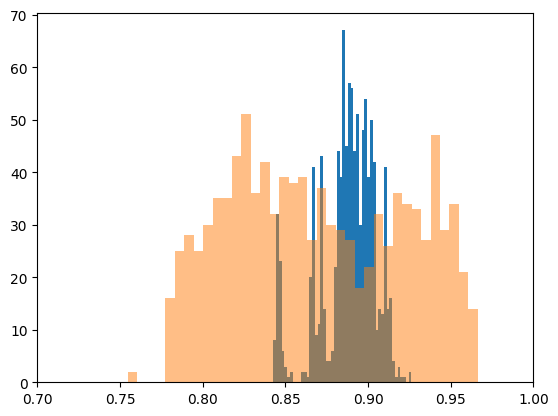

In [113]:
score_col = 'kfold_mean_f1'

feature_1 = score.query('X_col == "org_coord"').query('ptcnt_type == 2').query('ptcnt >= 4')
feature_2 = score.query('X_col == "segment_vec"').query('ptcnt_type == 2').query('ptcnt >= 4')
feature_3 = score.query('X_col == "segment_cossim"').query('ptcnt_type == 2').query('ptcnt >= 4')
feature_4 = score.query('X_col == "startend_seg_cossim"').query('ptcnt_type == 2').query('ptcnt >= 4')
feature_5 = score.query('X_col == "segment_grad_cossim"')
feature_6 = score.query('X_col == "startend_grad_cossim"')

plt.xlim([0.7, 1])
plt.hist(feature_1[score_col], bins=50)
# plt.hist(feature_2[score_col], bins=50, alpha=0.5)
# plt.hist(feature_3[score_col], bins=50, alpha=0.5)
# plt.hist(feature_4[score_col], bins=50, alpha=0.5)
plt.hist(feature_5[score_col], bins=50, alpha=0.5)
# plt.hist(feature_6[score_col], bins=50, alpha=0.5)
